In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers[torch] datasets accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.wh

In [ ]:
import pandas as pd
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import torch
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset


### **Looking at the Class Distribution**

Distribution of training data can have a big impact on training the model


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/CZ4034/train_labeled_lyrics_english.csv')
train_df = train_df.iloc[:, 1:]
train_df

,Unnamed: 0,artist,album,track,track_id,lyrics,duration,genre,emotion,intensity
0,18924,Linkin Park,LIVING THINGS: Acapellas and Instrumentals,SKIN TO BONE - Acapella,0jw00DFjpx3AjcPtVCS1st,"Skin to bone, steel to rust\nAsh to ashes, dus...",2 minutes 37 seconds,"['alternative metal', 'nu metal', 'post-grunge...",acceptance,low
1,22125,Ava Max,So Am I (The Remixes),So Am I - Toby Green Remix,26c18xZN2XSjK50hoYWQrz,Do you ever feel like a misfit?\nEverything in...,2 minutes 46 seconds,['pop'],acceptance,low
2,3717,Benson Boone,Hits 2024,Crazy,3lJkIVh6lYW0pERAtwu4kJ,Something don't feel right\nYou got a way with...,3 minutes 7 seconds,['singer-songwriter pop'],acceptance,low
3,12691,Billie Eilish,Sunset Vibes,Clown,6FAfVzdBlNrvks8hiOokCl,I guess it's funnier from where you're standin...,3 minutes 41 seconds,"['art pop', 'pop']",acceptance,low
4,13966,Lana Del Rey,Lust For Life,Get Free,761QvVHTibYjEi2r6A4g4Q,"Finally, I'm crossing the threshold\nFrom the ...",5 minutes 34 seconds,"['art pop', 'pop']",acceptance,low
...,...,...,...,...,...,...,...,...,...,...
1079,9179,Black Sabbath,The Eternal Idol (Deluxe Edition),The Shining (2009 Remaster),1lSUiRmzS2c1KGrZqaeMWV,There's a man who sees all there is to see\nWh...,5 minutes 58 seconds,"['album rock', 'alternative metal', 'birmingha...",vigilance,high
1080,22976,Slayer,Show No Mercy,Fight Till Death,5xFqDS7kANSCyzne6yqjIV,Metal and men clash once more to the end\nWarr...,3 minutes 37 seconds,"['alternative metal', 'death metal', 'groove m...",vigilance,high
1081,22627,Keshi,Sex Music 2022,First,6YY1WmsYGgTAwFWab6jHAY,Promise that you won't kiss and tell\nI'm for ...,3 minutes 26 seconds,['chill r&b'],vigilance,high
1082,16555,Elton John,Blue Moves,If There's A God In Heaven (What's He Waiting ...,0jfP8jD5xZBWXUJ0H36UKz,"Torn from their families, mothers go hungry\nT...",4 minutes 25 seconds,"['glam rock', 'mellow gold', 'piano rock', 'ro...",vigilance,high


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = 32
id2label = {
    "0": "serenity",
    "1": "joy",
    "2": "ecstasy",
    "3": "love",
    "4": "acceptance",
    "5": "trust",
    "6": "admiration",
    "7": "submission",
    "8": "apprehension",
    "9": "fear",
    "10": "terror",
    "11": "awe",
    "12": "distraction",
    "13": "surprise",
    "14": "amazement",
    "15": "disapproval",
    "16": "pensiveness",
    "17": "sadness",
    "18": "grief",
    "19": "remorse",
    "20": "boredom",
    "21": "disgust",
    "22": "loathing",
    "23": "contempt",
    "24": "annoyance",
    "25": "anger",
    "26": "rage",
    "27": "aggressiveness",
    "28": "interest",
    "29": "anticipation",
    "30": "vigilance",
    "31": "optimism"

}

label2id = {
    "serenity": 0,
    "joy": 1,
    "ecstasy": 2,
    "love": 3,
    "acceptance": 4,
    "trust": 5,
    "admiration": 6,
    "submission": 7,
    "apprehension": 8,
    "fear": 9,
    "terror": 10,
    "awe": 11,
    "distraction": 12,
    "surprise": 13,
    "amazement": 14,
    "disapproval": 15,
    "pensiveness": 16,
    "sadness": 17,
    "grief": 18,
    "remorse": 19,
    "boredom": 20,
    "disgust": 21,
    "loathing": 22,
    "contempt": 23,
    "annoyance": 24,
    "anger": 25,
    "rage": 26,
    "aggressiveness": 27,
    "interest": 28,
    "anticipation": 29,
    "vigilance": 30,
    "optimism": 31
}


In [ ]:
train_df["emotion"].value_counts()

emotion
ecstasy           139
joy               117
aggressiveness     93
grief              76
love               56
annoyance          52
loathing           51
anticipation       51
sadness            49
pensiveness        48
optimism           37
anger              37
admiration         34
apprehension       33
fear               30
rage               27
disgust            26
remorse            23
terror             17
vigilance          15
trust              14
interest           10
submission         10
serenity            9
contempt            8
awe                 8
acceptance          5
disapproval         4
boredom             2
surprise            2
distraction         1
Name: count, dtype: int64

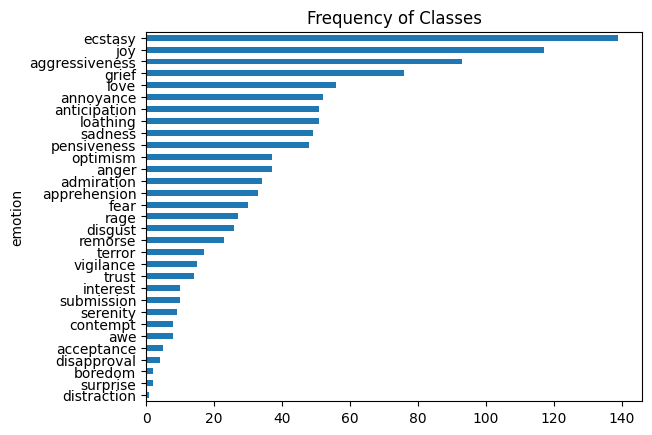

In [ ]:
train_df["emotion"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [ ]:
# train_df["emotion"] = train_df["emotion"].str.strip()
train_df["label"] = train_df["emotion"].apply(lambda x: label2id[x])
train_df

,Unnamed: 0,artist,album,track,track_id,lyrics,duration,genre,emotion,intensity,label
0,18924,Linkin Park,LIVING THINGS: Acapellas and Instrumentals,SKIN TO BONE - Acapella,0jw00DFjpx3AjcPtVCS1st,"Skin to bone, steel to rust\nAsh to ashes, dus...",2 minutes 37 seconds,"['alternative metal', 'nu metal', 'post-grunge...",acceptance,low,4
1,22125,Ava Max,So Am I (The Remixes),So Am I - Toby Green Remix,26c18xZN2XSjK50hoYWQrz,Do you ever feel like a misfit?\nEverything in...,2 minutes 46 seconds,['pop'],acceptance,low,4
2,3717,Benson Boone,Hits 2024,Crazy,3lJkIVh6lYW0pERAtwu4kJ,Something don't feel right\nYou got a way with...,3 minutes 7 seconds,['singer-songwriter pop'],acceptance,low,4
3,12691,Billie Eilish,Sunset Vibes,Clown,6FAfVzdBlNrvks8hiOokCl,I guess it's funnier from where you're standin...,3 minutes 41 seconds,"['art pop', 'pop']",acceptance,low,4
4,13966,Lana Del Rey,Lust For Life,Get Free,761QvVHTibYjEi2r6A4g4Q,"Finally, I'm crossing the threshold\nFrom the ...",5 minutes 34 seconds,"['art pop', 'pop']",acceptance,low,4
...,...,...,...,...,...,...,...,...,...,...,...
1079,9179,Black Sabbath,The Eternal Idol (Deluxe Edition),The Shining (2009 Remaster),1lSUiRmzS2c1KGrZqaeMWV,There's a man who sees all there is to see\nWh...,5 minutes 58 seconds,"['album rock', 'alternative metal', 'birmingha...",vigilance,high,30
1080,22976,Slayer,Show No Mercy,Fight Till Death,5xFqDS7kANSCyzne6yqjIV,Metal and men clash once more to the end\nWarr...,3 minutes 37 seconds,"['alternative metal', 'death metal', 'groove m...",vigilance,high,30
1081,22627,Keshi,Sex Music 2022,First,6YY1WmsYGgTAwFWab6jHAY,Promise that you won't kiss and tell\nI'm for ...,3 minutes 26 seconds,['chill r&b'],vigilance,high,30
1082,16555,Elton John,Blue Moves,If There's A God In Heaven (What's He Waiting ...,0jfP8jD5xZBWXUJ0H36UKz,"Torn from their families, mothers go hungry\nT...",4 minutes 25 seconds,"['glam rock', 'mellow gold', 'piano rock', 'ro...",vigilance,high,30


# In this case, we can see that the dataset is heavily imbalanced; ecstasy and joy classes appear frequently, whereas surprise and distraction are more than 100 times rarer.

## To deal with imbalanced data, we can either:

* **Randomly oversample the minority class.**
* **Randomly undersample the majority class.**
* **Gather more labeled data from the underrepresented classes.**
